# Process texts and word align


# Steps:

## PART I

    (1) Look at data

    (2) Combine into a single tab-delimited file 

    (3)(1) Sort & remove duplicate lines & (2) Remove near duplicate lines

    (4) Remove lines where SRC == TRG or where SRC ~= TRG

    (5) Word tokenize (+ remove punct, digits, stop words) 

    (6)(1) Remove outliers (where diff in sentence length between SRC and TRG is too large) & (2) Remove too long sentences

## PART II

    (1) Word align

    (2) Extract Glossary

## PART I

### (1) Look at data

In [1]:
!pwd

/Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks


In [2]:
PROC_DATA_PREFIX = '/Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data'

In [3]:
# Number of lines in SRC file and TRG file
!wc -l {PROC_DATA_PREFIX}/s_res_en
!wc -l {PROC_DATA_PREFIX}/s_res_ru

   42421 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/s_res_en
   42421 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/s_res_ru


In [9]:
# word count
count = 0
with open(PROC_DATA_PREFIX + '/' + 's_res_en', 'r', encoding='utf8') as inF:
    for line in inF:
        count += len(preprocess(line.strip()).split())
print(count)

1182548


In [8]:
text = "◦ The Participation as a partner in an the international facility in Russia to provide enrichment services for a reliable supply of fuel to Iran's nuclear reactors."
len(preprocess(text.strip()).split())

21

In [10]:
# word count
count = 0
with open(PROC_DATA_PREFIX + '/' + 's_res_ru', 'r', encoding='utf8') as inF:
    for line in inF:
        count += len(preprocess(line.strip()).split())
print(count)

1263651


In [7]:
!head -4 {PROC_DATA_PREFIX}/s_res_en
!head -4 {PROC_DATA_PREFIX}/s_res_ru

Distr.
GENERAL
28 July 1993
RESOLUTION 852 (1993)
Distr.
GENERAL
28 July 1993
РЕЗОЛЮЦИЯ 852 (1993),


In [9]:
!tail -1 {PROC_DATA_PREFIX}/s_res_en
!tail -1 {PROC_DATA_PREFIX}/s_res_ru

22. Recalls the request, in resolution 2178 (2014), to the Analytical Support and Sanctions Monitoring Team, in close cooperation with all relevant United Nations counter-terrorism bodies, to report to the Committee pursuant to resolution 1267 (1999) and 1989 (2011) within 180 days, on the threat posed by foreign terrorist fighters recruited by or joining ISIL, ANF, and all groups, undertakings, and entities associated with Al-Qaida, and reiterates that this report should also focus on trends related to foreign terrorist fighters joining and working with all terrorist groups listed on the 1267 Al-Qaida Sanctions List, and should include an oral briefing to the Committee and a Committee brief to the Security Council at the next regular briefing on counter-terrorism on those operating in Africa.
22. напоминает о просьбе, адресованной в резолюции 2178 (2014) Группе по аналитической поддержке и наблюдению за санкциями и заключающейся в том, чтобы она, действуя в тесном сотрудничестве со вс

### (2) Combine into a single tab-delimited file

In [12]:
!paste {PROC_DATA_PREFIX}/s_res_en {PROC_DATA_PREFIX}/s_res_ru > \
       {PROC_DATA_PREFIX}/en_ru

!wc -l {PROC_DATA_PREFIX}/en_ru
!head -4 {PROC_DATA_PREFIX}/en_ru

   42421 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru
Distr.	Distr.
GENERAL	GENERAL
28 July 1993	28 July 1993
RESOLUTION 852 (1993)	РЕЗОЛЮЦИЯ 852 (1993),


### (3)(1) Sort & remove duplicate lines 

In [14]:
!sort -u {PROC_DATA_PREFIX}/en_ru > {PROC_DATA_PREFIX}/en_ru_sort_uniq
!wc -l {PROC_DATA_PREFIX}/en_ru_sort_uniq
!head -4 {PROC_DATA_PREFIX}/en_ru_sort_uniq

   35367 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq
− Alphons Orie (The Netherlands)	- Алфонс Ори (Нидерланды)
− Antoine Kesia-Mbe Mindua (Democratic Republic of Congo)	- Антуан Кесия-Мбе Миндуа (Демократическая Республика Конго)
− Bakone Justice Moloto (South Africa)	- Баконе Джастис Молото (Южная Африка)
− Burton Hall (The Bahamas)	- Бертон Холл (Багамские Острова)


In [15]:
!tail -4 {PROC_DATA_PREFIX}/en_ru_sort_uniq

Árpád Prandler (Hungary)	Арпат Прандлер (Венгрия)
◦ Development with IAEA of a standing multilateral mechanism for reliable access to nuclear fuel, based on ideas to be considered at the next meeting of the Board of Governors.	:: создания совместно с МАГАТЭ постоянного многостороннего механизма надежного обеспечения доступа к ядерному топливу на основе идей, которые будут рассмотрены на следующем заседании Совета управляющих.
◦ Establishment on commercial terms of a buffer stock to hold a reserve of up to five years' supply of nuclear fuel dedicated to Iran, with the participation and under supervision of IAEA.	:: создания на коммерческих началах резервных запасов предназначенного для Ирана ядерного топлива, рассчитанных на пять лет, при участии и под контролем МАГАТЭ;
◦ Participation as a partner in an international facility in Russia to provide enrichment services for a reliable supply of fuel to Iran's nuclear reactors.	:: привлечения его в качестве партнера к работе находящегося в 

### (3)(2) Remove near duplicate lines

In [16]:
import nltk
from nltk.metrics.distance import jaro_similarity

In [17]:
# Get rid of near duplicate lines
# takes long - wait !
threshold = 0.85
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq', 'r', encoding='utf8') as inF, \
     open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim', 'w', encoding='utf8') as toF:
    prev_line = inF.readline()
    for curr_line in inF:
        if jaro_similarity(prev_line, curr_line) > threshold:  # Two lines are very similar,
            prev_line = curr_line                              # forget previous line
        else:
            toF.write(prev_line)   # If not similar, put previous line into file,
            prev_line = curr_line  # then forget previous line

!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq'
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim'

   35367 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq
   28972 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim


### (4) Remove lines where SRC == TRG or where SRC ~= TRG

In [18]:
# Examples of similar SRC and TRG
!sed -n -e '34934{p;q;}' /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq

c. Location: Room 1610 Nan Fung Tower, 173 Des Voeux Road, Hong Kong	c. Место расположения: Room 1610 Nan Fung Tower, 173 Des Voeux Road, Hong Kong


In [19]:
!sed -n -e '28134{p;q;}' /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq

Recalling its resolutions 1267 (1999), 1333 (2000), 1363 (2001), 1373 (2001), 1390 (2002), 1452 (2002), 1455 (2003), 1526 (2004), 1566 (2004), 1617 (2005), 1624 (2005), 1699 (2006), 1730 (2006), 1735 (2006), and 1822 (2008), and the relevant statements of its President,	ссылаясь на свои резолюции 1267 (1999), 1333 (2000), 1363 (2001), 1373 (2001), 1390 (2002), 1452 (2002), 1455 (2003), 1526 (2004), 1566 (2004), 1617 (2005), 1624 (2005), 1699 (2006), 1730 (2006), 1735 (2006) и 1822 (2008) и на соответствующие заявления своего Председателя,


In [20]:
# SRC and TRG are very similar
str1 = "95-37553 (E) 281195"
str2 = "95-37555.R 281195 281195"
jaro_similarity(str1, str2)

0.7826023391812865

In [21]:
# SRC and TRG are not similar
str1 = """Гуманитарный призыв"""
str2 = """Humanitarian appeal"""
jaro_similarity(str1, str2)

0.36842105263157887

In [23]:
# Count all similarity scores - takes long - wait !
jaro_simil_scores_list = []
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim', 'r', encoding='utf8') as inF, \
     open(PROC_DATA_PREFIX + '/' + 'sim_scores.txt', 'w', encoding='utf8') as toF:
    for line in inF:
        line_list = line.split('\t')
        src_str, trg_str = line_list[0].strip(), line_list[1].strip()
        sim_score = jaro_similarity(src_str, trg_str)
        jaro_simil_scores_list.append(sim_score)
        toF.write('{}\n'.format(sim_score))

print(len(jaro_simil_scores_list))
!wc -l {PROC_DATA_PREFIX}/sim_scores.txt
!wc -l {PROC_DATA_PREFIX}/en_ru_sort_uniq_remsim

28972
   28972 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/sim_scores.txt
   28972 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim


In [25]:
# Keep lines where SRC and TRG are very distinct
threshold = 0.45
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim', 'r', encoding='utf8') as inF_text, \
    open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro', 'w', encoding='utf8') as toF_text:
    for i, line in enumerate(inF_text):
        if jaro_simil_scores_list[i] < threshold:  # If SRC and TRG are not too simialr, keep the line
            toF_text.write(line)

!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro'

   25971 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro


### (5) Word tokenize (+ remove punct, digits, stop words) 

In [1]:
import string
import nltk

stopwords = ['the', 'a', 'an', 'of',
#              's', 'and', 'и', 'or', 'или',   # Inclusion of these into stop words 
#              'been', 'being', 'by'           # causes word alignment to deteriorate
            ]

def preprocess(text):
    """Return a string cleaned up."""
    text = text.lower()  # lowercase
    # word-tokenize & remove numbers if the entire token consists of numbers
    text = ' '.join(t for t in nltk.wordpunct_tokenize(text) if not t.isdigit() and not t in stopwords)
    # remove punctuation
    punct_remove = set(string.punctuation) | {'−', '\t', '\n', '\r', '\x0b', '\x0c', '◦', '°'}
    text = ''.join(char for char in text if char not in punct_remove)
    # strip extra whitespaces
    text = ' '.join(text.split())
    return text

In [27]:
# check if it works as expected
# text = """!"#$%&'()*+,-−./:;<=>?@[\]^_`{|}~"""
text = "◦ The Participation as a partner in an the international facility in Russia to provide enrichment services for a reliable supply of fuel to Iran's nuclear reactors."
preprocess(text)

'participation as partner in international facility in russia to provide enrichment services for reliable supply fuel to iran s nuclear reactors'

In [28]:
# Word tokenize and clean up - from now on I have two files - raw text and tokenized text
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro', 'r', encoding='utf8') as inF, \
     open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_tok', 'w', encoding='utf8') as toF:
    for line in inF:
        line_list = line.split('\t')
        src_str, trg_str = line_list[0].strip(), line_list[1].strip()
        toF.write('{}\t{}\n'.format(preprocess(src_str), preprocess(trg_str)))

In [29]:
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro'
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_tok'

   25971 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro
   25971 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_tok


In [30]:
print('BEFORE\n')
!head -2 {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro'
!tail -2 {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro'
print('\nAFTER\n')
!head -2 {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_tok'
!tail -2 {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_tok'

BEFORE

− Antoine Kesia-Mbe Mindua (Democratic Republic of Congo)	- Антуан Кесия-Мбе Миндуа (Демократическая Республика Конго)
− Howard Morrison (United Kingdom)	- Говард Моррисон (Соединенное Королевство)
◦ Development with IAEA of a standing multilateral mechanism for reliable access to nuclear fuel, based on ideas to be considered at the next meeting of the Board of Governors.	:: создания совместно с МАГАТЭ постоянного многостороннего механизма надежного обеспечения доступа к ядерному топливу на основе идей, которые будут рассмотрены на следующем заседании Совета управляющих.
◦ Establishment on commercial terms of a buffer stock to hold a reserve of up to five years' supply of nuclear fuel dedicated to Iran, with the participation and under supervision of IAEA.	:: создания на коммерческих началах резервных запасов предназначенного для Ирана ядерного топлива, рассчитанных на пять лет, при участии и под контролем МАГАТЭ;

AFTER

antoine kesia mbe mindua democratic republic congo	антуа

### (6)(1) Remove outliers (where diff in sentence length between SRC and TRG is too large)

In [31]:
# Count sentence lengths
def count_sent_len(data_prefix, file_in, file_out):
    """Count sentence length in tab-delim file_in and write counts to file_out."""
    with open(data_prefix + '/' + file_in, 'r', encoding='utf8') as inF, \
        open(data_prefix + '/' + file_out, 'w', encoding='utf8') as toF_nums:
        for line in inF:
            line_list = line.split('\t')
            src_str, trg_str = line_list[0].strip(), line_list[1].strip()
            src_len, trg_len = len(src_str.split()), len(trg_str.split())
            toF_nums.write('{}\t{}\n'.format(src_len, trg_len))

In [32]:
count_sent_len(PROC_DATA_PREFIX, 'en_ru_sort_uniq_remsim_jaro_tok', 'sent_lengths.txt')

In [33]:
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_tok'
!wc -l {PROC_DATA_PREFIX}/'sent_lengths.txt'
!head -3 {PROC_DATA_PREFIX}/'sent_lengths.txt'

   25971 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_tok
   25971 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/sent_lengths.txt
7	7
4	4
4	4


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

my_data = pd.read_csv(PROC_DATA_PREFIX + '/' + 'sent_lengths.txt', sep='\t', header=None)
my_data.columns = ['src_len', 'trg_len']

In [35]:
my_data['diff'] = my_data.loc[:, 'src_len'] - my_data.loc[:, 'trg_len']
my_data.head()

,src_len,trg_len,diff
0,7,7,0
1,4,4,0
2,4,4,0
3,5,5,0
4,5,5,0


In [36]:
my_data.tail()

,src_len,trg_len,diff
25966,39,38,1
25967,29,34,-5
25968,3,3,0
25969,23,24,-1
25970,25,21,4


In [39]:
# Calculate the mean difference and standard deviation of the difference in length
diff_mean = np.mean(my_data.loc[:, "diff"])
diff_std = np.std(my_data.loc[:, "diff"])
print('Mean difference and standard deviation of the difference in length between SRC and TRG senteces:')
print(diff_mean, diff_std)

Mean difference and standard deviation of the difference in length between SRC and TRG senteces:
-2.3534326749066268 4.74472866424436


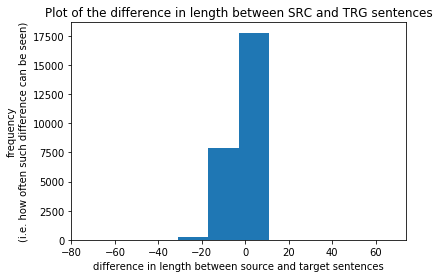

In [40]:
# Plot the differences
plt.hist(my_data.loc[:, "diff"])
plt.title('Plot of the difference in length between SRC and TRG sentences')
plt.xlabel("difference in length between source and target sentences")
plt.ylabel("frequency\n(i.e. how often such difference can be seen)")
plt.show()

In [ ]:
# The above shows that Russian translations are usually longer than the English sources

In [41]:
# Maximum number of standard deviations allowed in the difference 
# in length between the source and target sentences
std = 2
limit_hi = diff_mean + std * diff_std
limit_lo = diff_mean - std * diff_std
print(limit_lo, limit_hi)

-11.842890003395347 7.136024653582094


In [42]:
# Inspect sentences regarded as outliers by the above standard 
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_tok', 'r', encoding='utf8') as inF, \
     open(PROC_DATA_PREFIX + '/' + 'outliers_at_2_std.txt', 'w', encoding='utf8') as toF:
    for idx, line in enumerate(inF):
        if (my_data.loc[:, "diff"][idx] > limit_hi) or (my_data.loc[:, "diff"][idx] < limit_lo):
            toF.write(line)  # write sentences where difference in length is outside of above limits

!wc -l {PROC_DATA_PREFIX}/'outliers_at_2_std.txt'
!head -3 {PROC_DATA_PREFIX}/'outliers_at_2_std.txt'

    1238 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/outliers_at_2_std.txt
security council encourages all ecowas states especially those most affected by illicit trade in small arms and light weapons to submit as did other states national reports on actions undertaken to implement united nations programme action for small arms and light weapons to secretary general in advance biennial review meeting	совет безопасности побуждает все государства эковас особенно те из них которые в наибольшей мере затрагивает незаконная торговля стрелковым оружием и легкими вооружениями представить генеральному секретарю как это сделали другие государства национальные доклады о принятых ими мерах по осуществлению программы действий организации объединенных наций по стрелковому оружию и легким вооружениям до начала проводимого раз в два года совещания по рассмотрению действия которое состоится в году
c l0 corrosion resistant multiple seal canned drive magnetic drive bellows or diaphra

In [43]:
# remove outliers from raw text & tokenized text files
# tokenized file first
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_tok', 'r', encoding='utf8') as inF, \
     open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_tok_2std', 'w', encoding='utf8') as toF:
    for idx, line in enumerate(inF):
        if (my_data.loc[:, "diff"][idx] < limit_hi) and (my_data.loc[:, "diff"][idx] > limit_lo):
            toF.write(line)  # keep line if difference is within above limits
            
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_tok'
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_tok_2std'

   25971 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_tok
   24733 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_tok_2std


In [44]:
# remove outliers from raw text & tokenized text files
# raw text next
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro', 'r', encoding='utf8') as inF, \
     open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_2std', 'w', encoding='utf8') as toF:
    for idx, line in enumerate(inF):
        if (my_data.loc[:, "diff"][idx] < limit_hi) and (my_data.loc[:, "diff"][idx] > limit_lo):
            toF.write(line)  # keep line if difference is within above limits
            
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro'
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_2std'

   25971 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro
   24733 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_2std


### (6)(2) Remove too long sentences

In [45]:
import pandas as pd

counts_data = pd.read_csv(PROC_DATA_PREFIX + '/' + 'sent_lengths.txt', sep='\t', header=None)
counts_data.columns = ['src_len', 'trg_len']
print(counts_data.shape)
counts_data.head()

(25971, 2)


,src_len,trg_len
0,7,7
1,4,4
2,4,4
3,5,5
4,5,5


In [46]:
# Remove too long sentences
# Raw file first -- This file is to go into Database
threshold = 40
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_2std', 'r', encoding='utf8') as inF, \
     open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_2std_40', 'w', encoding='utf8') as toF:
    for idx, line in enumerate(inF):
        if (counts_data.loc[:, 'src_len'][idx] < threshold) and (counts_data.loc[:, 'trg_len'][idx] < threshold):
            toF.write(line)  # keep lines which are less than 40 words long

In [48]:
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_2std'
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_2std_40'

   24733 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_2std
   14561 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_2std_40


In [49]:
# Remove too long sentences
# Tok file -- This file is be used for Word Alignment
threshold = 40
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_tok_2std', 'r', encoding='utf8') as inF, \
     open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_tok_2std_40', 'w', encoding='utf8') as toF:
    for idx, line in enumerate(inF):
        if (counts_data.loc[:, 'src_len'][idx] < threshold) and (counts_data.loc[:, 'trg_len'][idx] < threshold):
            toF.write(line)  # keep lines which are less than 40 words long

!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_tok_2std'
!wc -l {PROC_DATA_PREFIX}/'en_ru_sort_uniq_remsim_jaro_tok_2std_40'

   24733 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_tok_2std
   14561 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/en_ru_sort_uniq_remsim_jaro_tok_2std_40


## PART II

### (1) Word align

In [83]:
# Put SRC sentences and TRG sentences into lists of lists
corpus_en = []
corpus_ru = []
with open(PROC_DATA_PREFIX + '/' + 'en_ru_sort_uniq_remsim_jaro_tok_2std_40', 'r', encoding='utf8') as inF:
    for line in inF:
        line_list = line.split('\t')
        src_str, trg_str = line_list[0].strip(), line_list[1].strip()
        corpus_en.append(src_str.split())
        corpus_ru.append(trg_str.split())

In [84]:
print(corpus_en[:2])
print(corpus_ru[:2])

[['antoine', 'kesia', 'mbe', 'mindua', 'democratic', 'republic', 'congo'], ['howard', 'morrison', 'united', 'kingdom']]
[['антуан', 'кесия', 'мбе', 'миндуа', 'демократическая', 'республика', 'конго'], ['говард', 'моррисон', 'соединенное', 'королевство']]


In [85]:
assert len(corpus_en) == len(corpus_ru)

In [86]:
import nltk
from nltk.translate.api import AlignedSent
# from nltk.translate.ibm3 import IBMModel3  # takes forever to run, models 4 & 5 require an unclear PoS dict
from nltk.translate.ibm2 import IBMModel2

In [87]:
bitext = []
for en, ru in zip(corpus_en, corpus_ru):
    bitext.append(AlignedSent(en, ru))

In [88]:
# Before alignment
bitext[:2]

[AlignedSent(['antoine', 'kesia', 'mbe', 'mindua', 'democratic', 'republic', 'congo'], ['антуан', 'кесия', 'мбе', 'миндуа', 'демократическая', 'республика', 'конго'], Alignment([])),
 AlignedSent(['howard', 'morrison', 'united', 'kingdom'], ['говард', 'моррисон', 'соединенное', 'королевство'], Alignment([]))]

In [89]:
# Calculate alignments
ibm2 = IBMModel2(bitext, 10)

In [90]:
# AlignedSent objects after alignment
bitext[:2]

[AlignedSent(['antoine', 'kesia', 'mbe', 'mindua', 'democratic', 'republic', 'congo'], ['антуан', 'кесия', 'мбе', 'миндуа', 'демократическая', 'республика', 'конго'], Alignment([(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6)])),
 AlignedSent(['howard', 'morrison', 'united', 'kingdom'], ['говард', 'моррисон', 'соединенное', 'королевство'], Alignment([(0, 0), (1, 1), (2, 2), (3, 3)]))]

In [91]:
print(vars(bitext[0]))

{'_words': ['antoine', 'kesia', 'mbe', 'mindua', 'democratic', 'republic', 'congo'], '_mots': ['антуан', 'кесия', 'мбе', 'миндуа', 'демократическая', 'республика', 'конго'], '_alignment': Alignment([(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6)])}


In [92]:
# Example alignments
print(bitext[0]._words)
print(bitext[0]._mots)
print(bitext[0]._alignment)
bitext[0]._alignment

['antoine', 'kesia', 'mbe', 'mindua', 'democratic', 'republic', 'congo']
['антуан', 'кесия', 'мбе', 'миндуа', 'демократическая', 'республика', 'конго']
0-0 1-1 2-2 3-3 4-4 5-5 6-6


Alignment([(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6)])

In [93]:
len(bitext)

14561

### (2) Extract Glossary

In [94]:
# Look at how words align in the first sentence
for aligned_sent in bitext[0:1]:
    for pair in aligned_sent._alignment:
        print(pair)
        try:
            print(aligned_sent._words[pair[0]], '\t', aligned_sent._mots[pair[1]])
        except TypeError:
            print(aligned_sent._words[pair[0]], '\t', '--')

(0, 0)
antoine 	 антуан
(3, 3)
mindua 	 миндуа
(5, 5)
republic 	 республика
(6, 6)
congo 	 конго
(4, 4)
democratic 	 демократическая
(2, 2)
mbe 	 мбе
(1, 1)
kesia 	 кесия


In [95]:
# Write uncleaned Glossary to file
with open(PROC_DATA_PREFIX + '/' + 'lexicon40', 'w', encoding='utf8') as toF:
    for aligned_sent in bitext:
        for pair in aligned_sent._alignment:
            try:
                print(aligned_sent._words[pair[0]], '\t', aligned_sent._mots[pair[1]], file=toF)
            except TypeError:
                print(aligned_sent._words[pair[0]], '\t', '--', file=toF)

In [12]:
print('Number of lines in the resulting English-Russian glossary:')
!wc -l {PROC_DATA_PREFIX}/lexicon40

Number of lines in the resulting English-Russian glossary:
  381171 /Users/alexskrn/Documents/NLP/WordAlign/wordalign_notebooks/data/lexicon40
